# Combine_metrics

The first part of this code reads all CSV files from a specified directory, calculates Precision, Recall, and F1 scores for each class in the files, and handles potential missing columns by printing errors and skipping problematic files. It extracts suffixes from the filenames to label the metrics, combines results into a single DataFrame, and exports the metrics to a CSV file with a name that includes all suffixes.

The second part of this code evaluates the performance of multiple models combined. It aggregates multiple CSV files containing image data and class probabilities, calculates average probabilities for each class, and determines the class with the highest average for each image. It then adds this information as a new column and saves the results to a new CSV file.


In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

### Part 1

In [2]:
def compute_metrics(file_path):
    """Compute Precision, Recall, and F1 scores for each class in the given file."""
    df = pd.read_csv(file_path)
    classes = df['Label'].unique()
    metrics = {}
    
    for cls in classes:
        y_true = (df['Label'] == cls).astype(int)
        y_pred = (df['Pred'] == cls).astype(int)
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        metrics[cls] = {
            'Precision': precision * 100,
            'Recall': recall * 100,
            'F1_Score': f1 * 100
        }
    
    return metrics

def process_files_from_directory(directory, output_file):
    """Process all CSV files in the specified directory and save the results to a CSV file."""
    # Get all CSV file paths from the directory
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    
    all_metrics = []
    suffixes = []
    
    for file_path in file_paths:
        # Extract a suffix from the file name for labeling
        suffix = os.path.basename(file_path).replace('Plankton_imager_02_', '').replace('_Preds_test.csv', '')
        suffixes.append(suffix)
        
        # Compute metrics for the file
        metrics = compute_metrics(file_path)
        
        # Convert metrics to DataFrame
        df_metrics = pd.DataFrame(metrics).T
        df_metrics.columns = [f'{col}_{suffix}' for col in df_metrics.columns]
        
        # Append the DataFrame to the list
        all_metrics.append(df_metrics)
    
    # Combine all metrics DataFrames side by side
    df_combined = pd.concat(all_metrics, axis=1)
    
    # Reset the index to make 'Class' a column
    df_combined.reset_index(inplace=True)
    df_combined.rename(columns={'index': 'Class'}, inplace=True)
    
    # Format values to 2 decimal places
    df_combined = df_combined.round(2)
    
    # Create a suffix string for the output file name
    suffix_str = '_'.join(suffixes)
    
    # Set the output file path with all suffixes included
    #output_file_with_suffixes = os.path.join(directory, f"Metrics_{suffix_str}.csv")
    output_file_with_suffixes = os.path.join(f"preds/Metrics_{suffix_str}.csv")
    
    # Export the combined results to a CSV file
    df_combined.to_csv(output_file_with_suffixes, index=False)
    print(f"Metrics calculated and saved to {output_file_with_suffixes}")

In [3]:
%% time

# Directory containing CSV files
directory = "preds/Preds_test_set"

# Process files and save the results
process_files_from_directory(directory, None)

UsageError: Cell magic `%%` not found.


### Part 2

In [4]:
# Define the directory containing your CSV files
directory = 'preds/Preds_test_set'

# Find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Initialize lists to hold data
paths = []
filenames = []
labels = []
data = []

# Track all class columns
class_columns = set()

# Iterate through all CSV files
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Extract the columns of interest
    paths.extend(df['Path'])
    filenames.extend(df['Filename'])
    labels.extend(df['Label'])
    
    # Identify class columns
    current_class_columns = [col for col in df.columns if col not in ['Path', 'Filename', 'Label', 'Pred']]
    class_columns.update(current_class_columns)
    
    # Append relevant data
    data.append(df[['Path', 'Filename', 'Label'] + current_class_columns])

# Concatenate all data into a single DataFrame
all_data_df = pd.concat(data, ignore_index=True)

# Compute average values for each class column
averages = {}
for col in class_columns:
    averages[col] = all_data_df.groupby(['Path', 'Filename', 'Label'])[col].mean().reset_index()

# Merge average values back to the main DataFrame
result_df = all_data_df[['Path', 'Filename', 'Label']].drop_duplicates()
for col in class_columns:
    avg_df = averages[col].rename(columns={col: col + '_avg'})
    result_df = pd.merge(result_df, avg_df, on=['Path', 'Filename', 'Label'], how='left')

# Determine the column with the highest value for each row
def get_combo_pred(row):
    # Extract the class columns for this row
    class_columns = [col for col in result_df.columns if '_avg' in col]
    class_values = row[class_columns]
    # Find the index of the maximum value
    if class_values.empty:
        return None
    max_index = class_values.idxmax()
    # Extract the column name
    return max_index.replace('_avg', '')

# Add the Combo_pred column
result_df['Combo_pred'] = result_df.apply(get_combo_pred, axis=1)

# Define the output file name and save the result to CSV
output_file = 'preds/Averages_with_combo_pred.csv'
result_df.to_csv(output_file, index=False)

print(f'Average values and Combo_pred saved to {output_file}')


Average values and Combo_pred saved to preds/averages_with_combo_pred.csv


In [5]:
# Extracting the true labels and predictions
y_true = result_df['Label']
y_pred = result_df['Combo_pred']

# Calculate and display metrics
correct_predictions = result_df['Combo_pred'] == result_df['Label']
num_correct_predictions = correct_predictions.sum()

# Calculating precision, recall and F1 with 'macro' average
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')

# Printing the results
print(f"Total number of images in test set: {len(result_df)}")
print(f"Total number of Correct Predictions: {num_correct_predictions}")
print(f"Precision (macro-average): {precision * 100:.2f}%")
print(f"Recall (macro-average): {recall * 100:.2f}%")
print(f"F1 Score (macro-average): {f1 * 100:.2f}%")

Total number of images in test set: 757
Total number of Correct Predictions: 709
Precision (macro-average): 93.97%
Recall (macro-average): 90.86%
F1 Score (macro-average): 91.67%


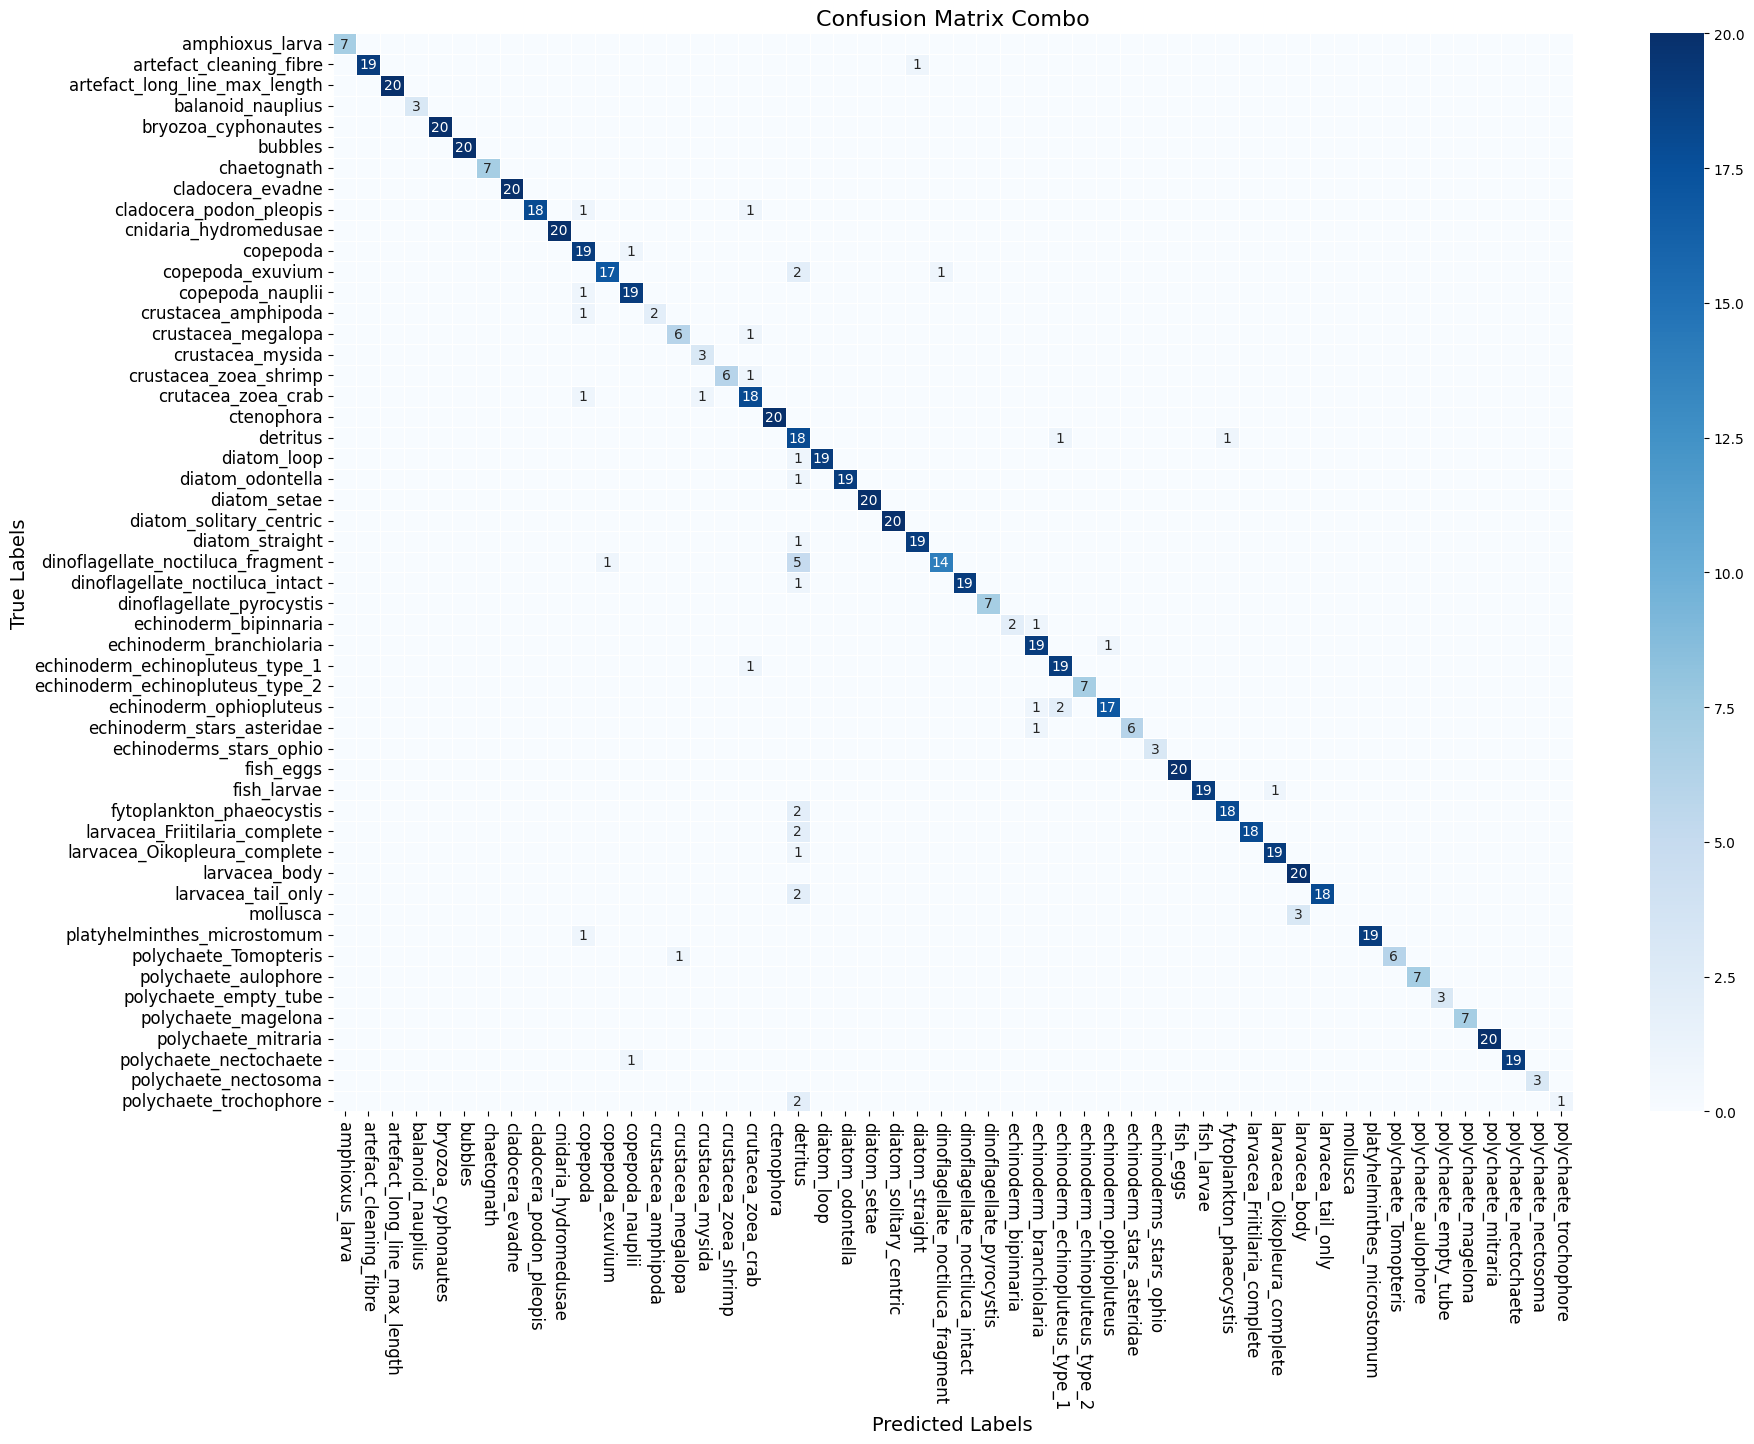

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define your class labels
class_labels = sorted(result_df['Label'].unique())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)

# Create a custom annotations array where zeroes are replaced with empty strings
annotations = np.where(cm == 0, '', cm)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(20, 14))

sns.heatmap(cm, annot=annotations, fmt='',  # Pass the custom annotations here
            cmap='Blues',
            cbar=True, 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            annot_kws={"size": 10},  # Set the font size for annotations
            linewidths=0.5,  # Optional: Add lines between cells for better readability
            linecolor='white'  # Optional: Line color between cells
           )

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Combo', fontsize=16)
plt.xticks(fontsize=12, rotation=-90)
plt.yticks(fontsize=12)

plt.show()

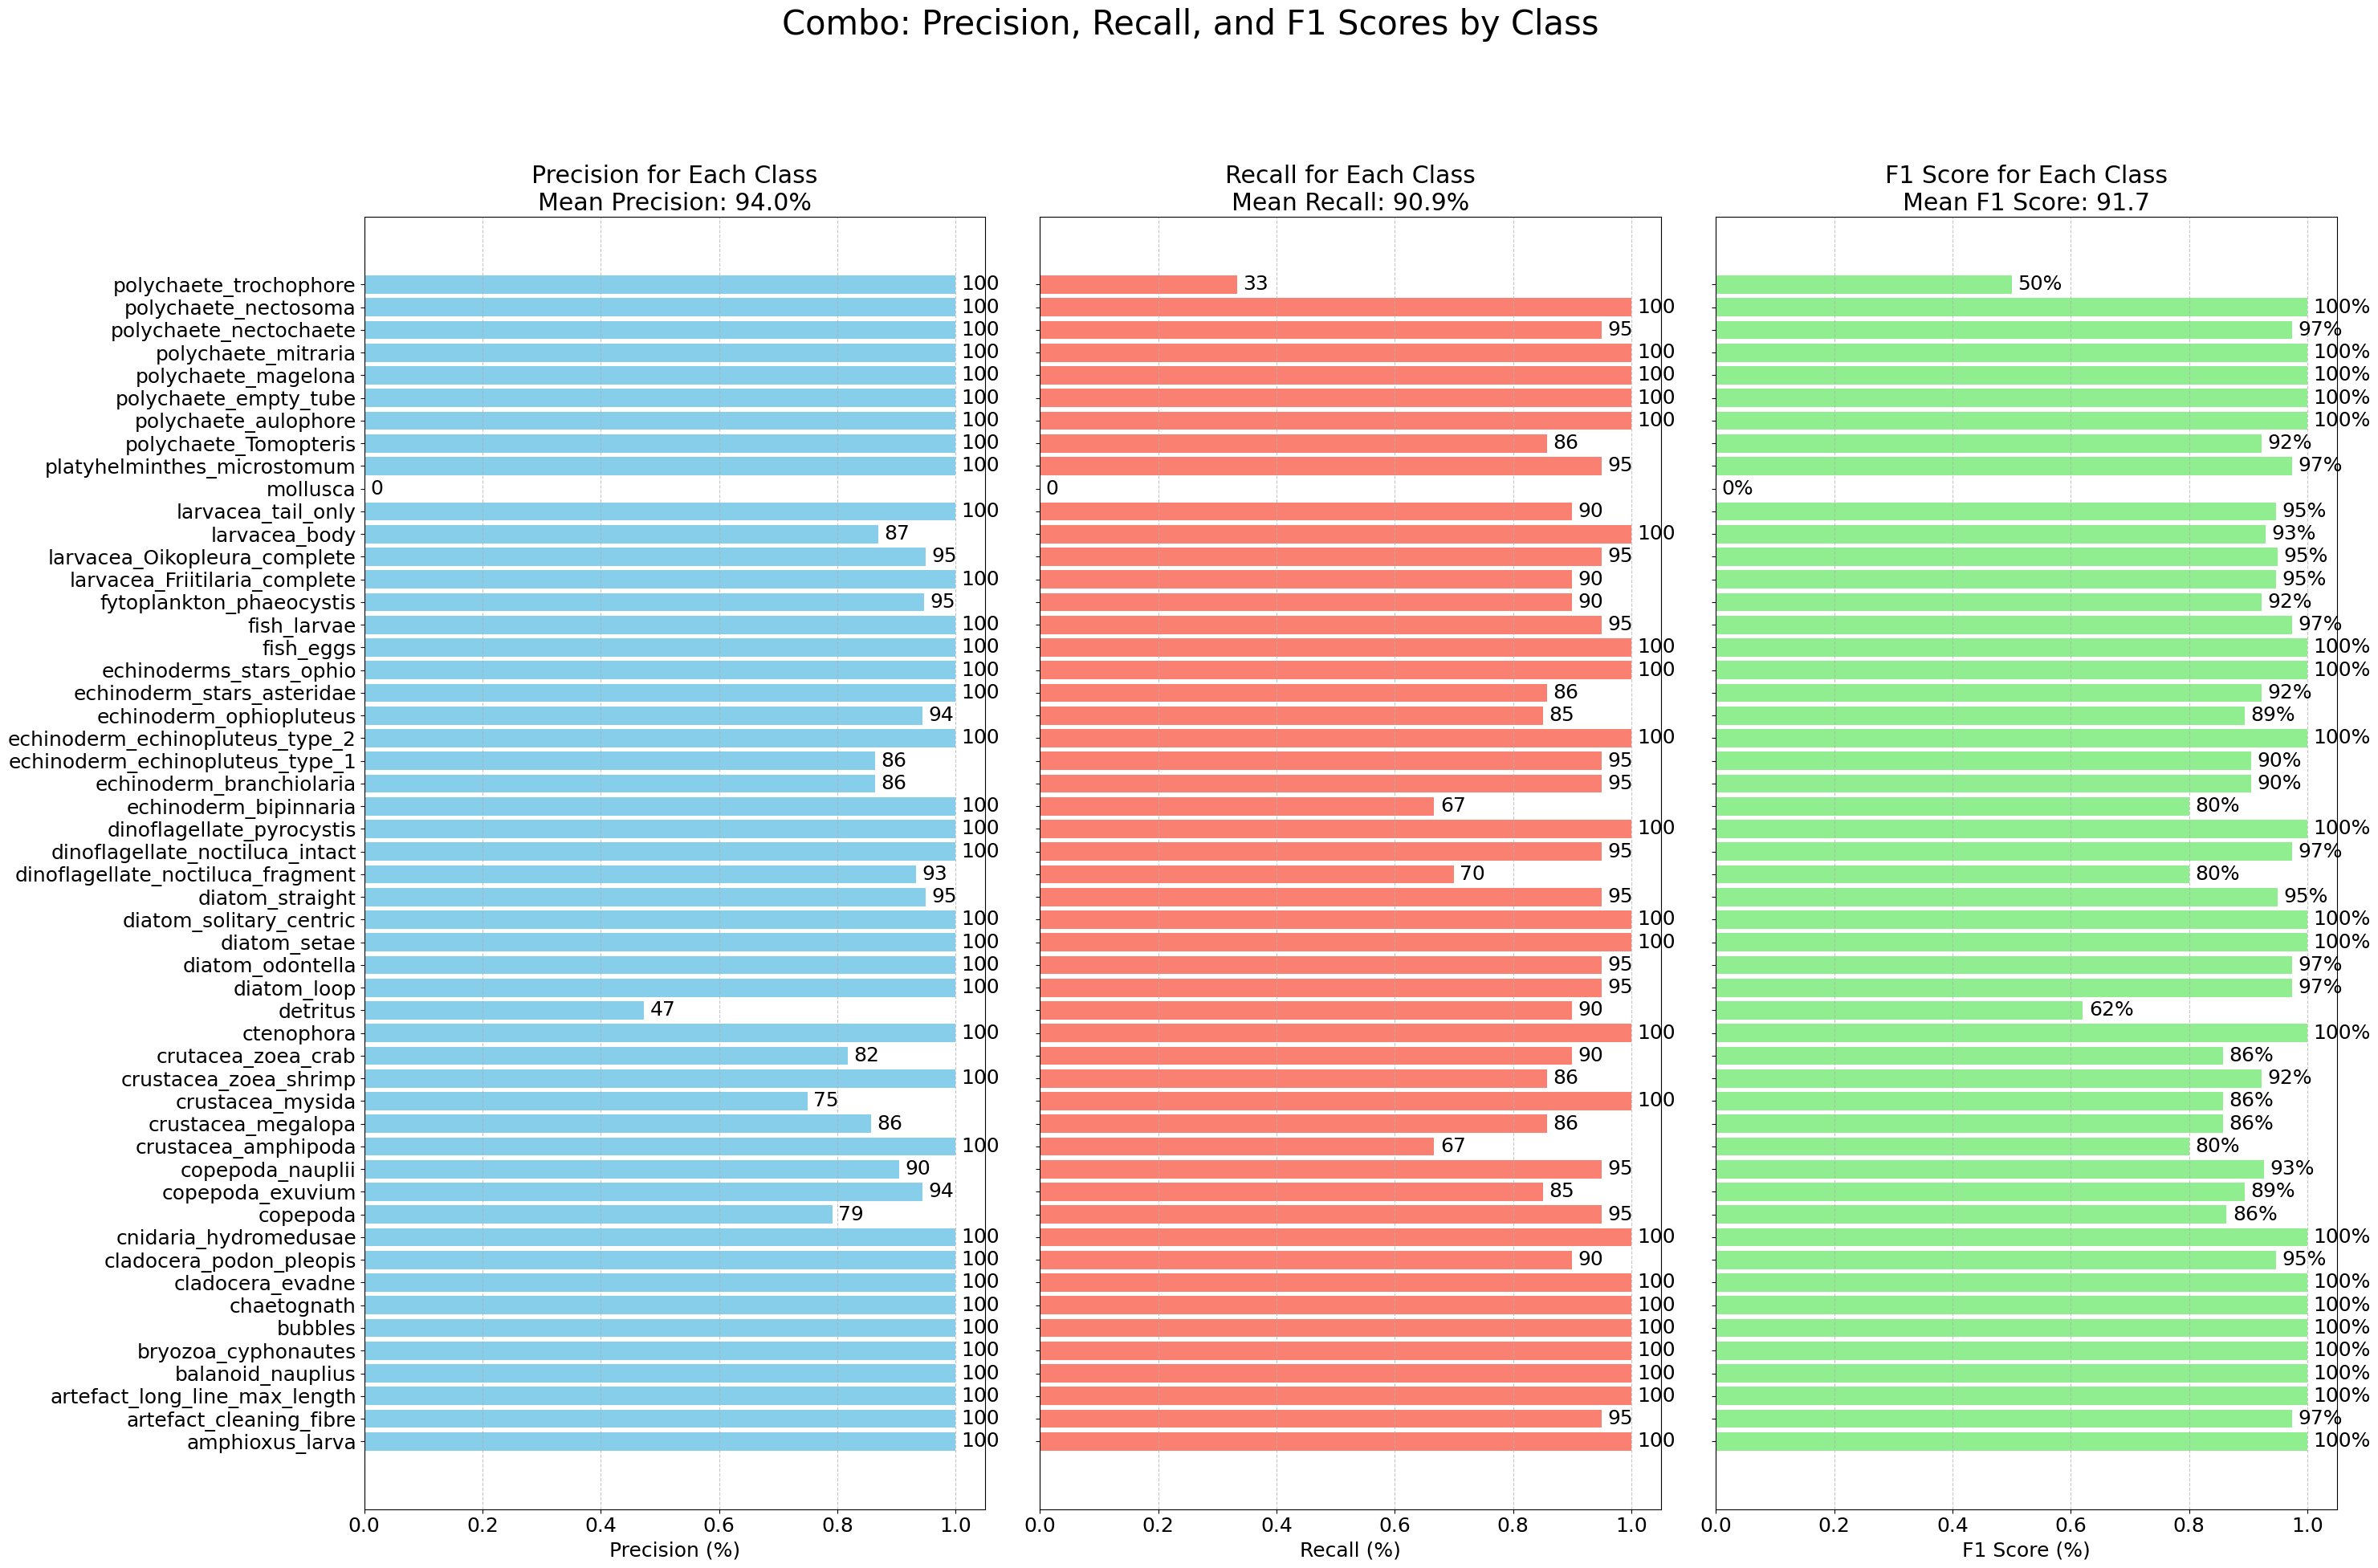

In [7]:
# Font size variable
font_size = 18  # Change this value to adjust font size

# Set global font size
plt.rcParams.update({'font.size': font_size})

# List of unique classes
unique_classes = result_df['Label'].unique()

# Initialize dictionaries for metrics
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate metrics
for cls in unique_classes:
    # Compute precision, recall, and F1 score for each class
    precision = precision_score(result_df['Label'], 
                                result_df['Combo_pred'], labels=[cls], average='macro', zero_division=0)
    recall = recall_score(result_df['Label'], 
                          result_df['Combo_pred'], labels=[cls], average='macro', zero_division=0)
    f1 = f1_score(result_df['Label'], 
                  result_df['Combo_pred'], labels=[cls], average='macro', zero_division=0)
    precision_scores[cls] = precision
    recall_scores[cls] = recall
    f1_scores[cls] = f1

# Convert to lists for plotting
sorted_classes = sorted(precision_scores.keys())
sorted_precisions = [precision_scores[cls] for cls in sorted_classes]
sorted_recalls = [recall_scores[cls] for cls in sorted_classes]
sorted_f1s = [f1_scores[cls] for cls in sorted_classes]

# Calculate mean values
mean_precision = sum(sorted_precisions) / len(sorted_precisions)
mean_recall = sum(sorted_recalls) / len(sorted_recalls)
mean_f1 = sum(sorted_f1s) / len(sorted_f1s)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(30, 20), sharey=True)

# Plot Precision
axes[0].barh([str(cls) for cls in sorted_classes], sorted_precisions, color='skyblue')
axes[0].set_xlabel('Precision (%)')
axes[0].set_title(f'Precision for Each Class\nMean Precision: {mean_precision*100:.1f}%')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
# Add mean values for each class to the precision panel
for i, cls in enumerate(sorted_classes):
    axes[0].text(sorted_precisions[i] + 0.01, i, f'{sorted_precisions[i]*100:.0f}', va='center', ha='left')

# Plot Recall
axes[1].barh([str(cls) for cls in sorted_classes], sorted_recalls, color='salmon')
axes[1].set_xlabel('Recall (%)')
axes[1].set_title(f'Recall for Each Class\nMean Recall: {mean_recall*100:.1f}%')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
# Add mean values for each class to the recall panel
for i, cls in enumerate(sorted_classes):
    axes[1].text(sorted_recalls[i] + 0.01, i, f'{sorted_recalls[i]*100:.0f}', va='center', ha='left')

# Plot F1 Score
axes[2].barh([str(cls) for cls in sorted_classes], sorted_f1s, color='lightgreen')
axes[2].set_xlabel('F1 Score (%)')
axes[2].set_title(f'F1 Score for Each Class\nMean F1 Score: {mean_f1*100:.1f}')
axes[2].grid(axis='x', linestyle='--', alpha=0.7)
# Add mean values for each class to the F1 score panel
for i, cls in enumerate(sorted_classes):
    axes[2].text(sorted_f1s[i] + 0.01, i, f'{sorted_f1s[i]*100:.0f}%', va='center', ha='left')

plt.suptitle('Combo: Precision, Recall, and F1 Scores by Class', fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make space for suptitle
plt.show()
